In [5]:
import pandas as pd
import numpy as np
import haversine as hs
import matplotlib.pyplot as plt
from IPython.display import clear_output
from datetime import datetime, date, timedelta

In [18]:
trem_17 = load_tremor('tremor_events2017.csv')
trem_18 = load_tremor('tremor_events2018.csv')
trem_19 = load_tremor('tremor_events2019.csv')
trem_20 = load_tremor('tremor_events2020.csv')
trem_21 = load_tremor('tremor_events2021.csv')

tremor_df = pd.concat([trem_17, trem_18, trem_19, trem_20, trem_21])

location_df = pd.read_csv('station_lon_lat', delim_whitespace=True, header=None, names=['name','lon','lat'])
coast_df = pd.read_csv('PNWcoast.dat',delim_whitespace=True, header=None, names=['lon', 'lat'])

In [16]:
def load_tremor(file_name):

    tremor_df = pd.read_csv(file_name)
    tremor_df.columns = ['lat','lon','depth','date']
    tremor_df['date']=pd.to_datetime(tremor_df['date'])
    tremor_df['date']=tremor_df['date'].dt.date
    
    return tremor_df

In [3]:
def get_counts(start, end, nearby_tremor):
    
    date_rng=pd.date_range(start=start, end=end, freq='D')
    timeline=pd.DataFrame(date_rng, columns=['date'])
    timeline['date'] = timeline['date'].dt.date
    timeline['counts'] = 0

    date_counts = nearby_tremor.groupby(['date']).count()
    date_counts.reset_index(inplace=True)
    date_counts = date_counts.drop(['lat','lon','distance'], axis=1)
    date_counts.columns=['date','count']
    
    for index, row in date_counts.iterrows():
        idx = np.where(timeline['date'] == row['date'])
        timeline.iloc[idx[0][0],timeline.columns.get_loc('counts')] = row['count']
    
    return timeline

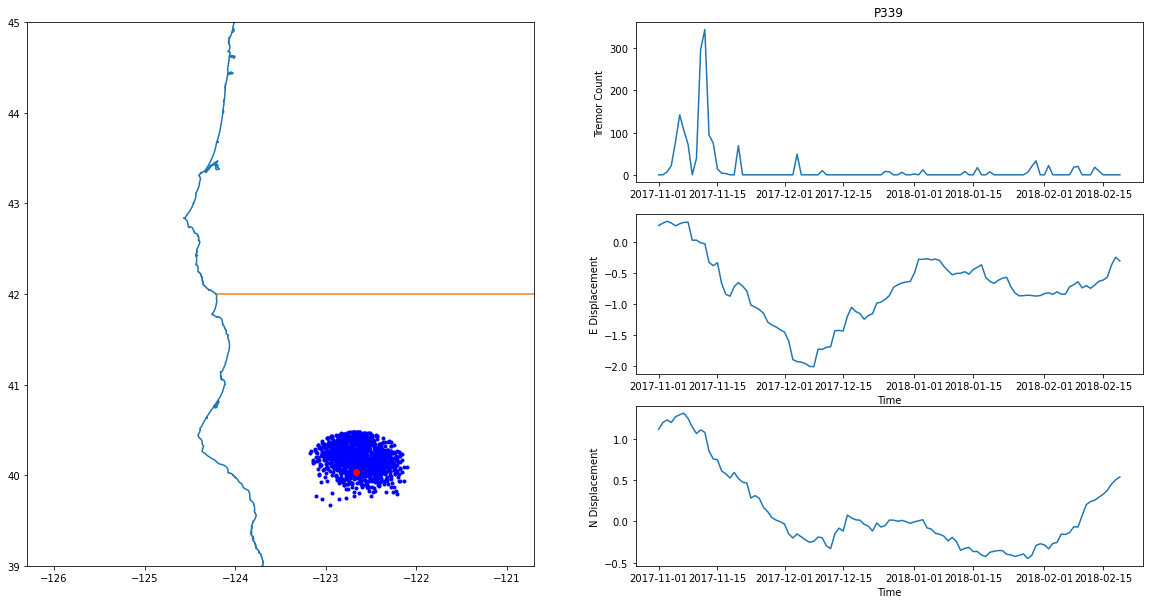

KeyboardInterrupt: Interrupted by user

In [20]:
start_date=pd.to_datetime(date(2017,12,1) - timedelta(days=30))
end_date=pd.to_datetime(date(2018,1,20) + timedelta(days=30)) 

for index, row in location_df.iterrows():

    station_pos = (location_df['lat'].iloc[index],location_df['lon'].iloc[index])
    file = location_df['name'].iloc[index] + '_cleaned.txt'
    GPS_df = pd.read_csv(file, header=None, delim_whitespace=True, names=['date','date time','N','E','U',
                                                                                       'sN','sE','sU'])
    GPS_df['date']=pd.to_datetime(GPS_df['date'])
    GPS_df.drop('date time', axis=1, inplace=True)

    #add column for distance between station and tremor
    tremor_df['distance'] = tremor_df.apply(lambda row: hs.haversine((row.lat,row.lon),station_pos), axis=1)

    #only keep tremor within 30km of the station
    close_tremor = tremor_df[tremor_df['distance'] < 50]

    #only keep tremor and GPS with a month of either end of the time window
    mask = (close_tremor['date'] >= start_date) & (close_tremor['date'] <= end_date)
    close_tremor = close_tremor.loc[mask]

    mask = (GPS_df['date'] >= start_date) & (GPS_df['date'] <= end_date)
    GPS_df = GPS_df.loc[mask]

    timeline = get_counts(start_date, end_date, close_tremor)

    plt.figure(figsize=(20,10))
    ax1 = plt.subplot(1,2,1)

    ax1.plot(coast_df['lon'],coast_df['lat'])
    ax1.plot([-124.2,-120],[42,42])
    ax1.axis('equal')
    ax1.set_xlim(-126,-121)
    ax1.set_ylim(39,45)
    ax1.plot(close_tremor['lon'],close_tremor['lat'],'b.')
    ax1.plot(station_pos[1],station_pos[0],'ro')

    ax2 = plt.subplot(3,2,2)
    ax2.plot(timeline['date'],timeline['counts'])
    ax2.set_ylabel('Tremor Count')
    ax2.set_title(location_df['name'].iloc[index])

    ax3 = plt.subplot(3,2,4)
    ax3.plot(GPS_df['date'],GPS_df['E'])
    ax3.set_xlabel('Time')
    ax3.set_ylabel('E Displacement')
    
    ax4 = plt.subplot(3,2,6)
    ax4.plot(GPS_df['date'],GPS_df['N'])
    ax4.set_xlabel('Time')
    ax4.set_ylabel('N Displacement')

    plt.show()
    input("Enter")  #option to have the code pause for each station and require the user to press "enter" to continue
    clear_output()
    
plt.close('all')

In [444]:
file= location_df['name'].iloc[0] +'.txt'

In [445]:
file

'CABL.txt'

In [19]:
tremor_df

,lat,lon,depth,date
0,47.612588,-123.464952,24.827586,2017-01-01
1,47.627120,-123.383312,20.000000,2017-01-01
2,47.630526,-123.397827,20.000000,2017-01-01
3,47.460558,-123.222292,22.068966,2017-01-01
4,47.684598,-123.382243,20.000000,2017-01-01
...,...,...,...,...
32861,41.579614,-122.748554,60.000000,2021-06-30
32862,41.361839,-122.711382,60.000000,2021-06-30
32863,41.245009,-122.816041,34.693878,2021-06-30
32864,41.207366,-122.791337,33.877551,2021-06-30
